In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ephem
from category_encoders import TargetEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, r2_score
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import joblib
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [2]:
# Load data
df = pd.read_excel("combined.xlsx")
df = df.drop(columns=["Unnamed: 3"], errors='ignore')
df = df.dropna(subset=["Percentagediff", "Date"])

# Create target
df['Target'] = df['Percentagediff'].apply(lambda x: 1 if x > 0 else 0)
target_label_map = {0: 'Negative', 1: 'Positive'}

# Date features
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

C:\Users\ANKITH\AppData\Local\Temp\ipykernel_15852\2183297379.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
def moon_phase(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.phase

df['LunarPhase'] = df['Date'].apply(moon_phase)
df['NearFullMoon'] = (df['LunarPhase'] > 95).astype(int)
df['NearNewMoon'] = (df['LunarPhase'] < 5).astype(int)

# Categorical & interaction features
categorical_cols = ['Nakshatra', 'Tithi', 'Karna', 'Yoga']
df['Nak_Tithi'] = df['Nakshatra'].astype(str) + "_" + df['Tithi'].astype(str)
df['Yoga_Karna'] = df['Yoga'].astype(str) + "_" + df['Karna'].astype(str)
interaction_cols = ['Nak_Tithi', 'Yoga_Karna']
date_features = ['DayOfWeek']
moon_features = ['LunarPhase', 'NearFullMoon', 'NearNewMoon']


In [4]:

# --- Rolling Statistics ---
df['RollingMean_3'] = df['Percentagediff'].rolling(window=3).mean()
df['RollingStd_3'] = df['Percentagediff'].rolling(window=3).std()

# --- Previous Day Change ---
df['PrevDayChange'] = df['Percentagediff'].shift(1)

# --- Group Target Mean Encoding ---
for col in categorical_cols:
    agg = df.groupby(col)['Target'].mean().rename(f"{col}_target_mean")
    df = df.merge(agg, on=col, how='left')

extra_features = ['RollingMean_3', 'RollingStd_3', 'PrevDayChange'] + [f"{col}_target_mean" for col in categorical_cols]
feature_medians = {col: df[col].median() for col in extra_features}



In [ ]:
feature_cols = categorical_cols + interaction_cols + date_features + moon_features + extra_features
# Drop rows with NA after rolling and shifting
df = df.dropna(subset=feature_cols + ['Target'])

# Target encode categorical + interaction features
encoder = TargetEncoder(cols=categorical_cols + interaction_cols)
df[categorical_cols + interaction_cols] = encoder.fit_transform(df[categorical_cols + interaction_cols], df['Target'])
# Prepare input/output
X = df[feature_cols].values
y = df['Target'].values


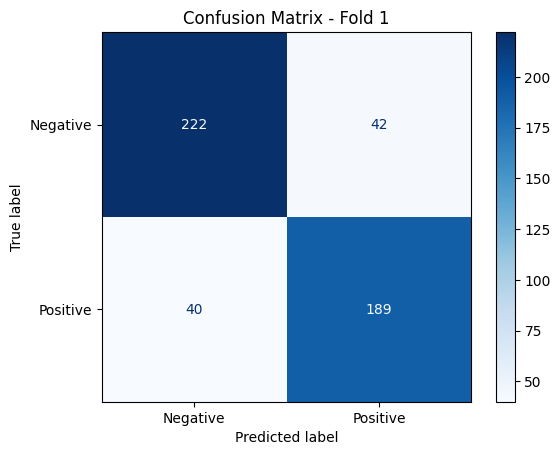

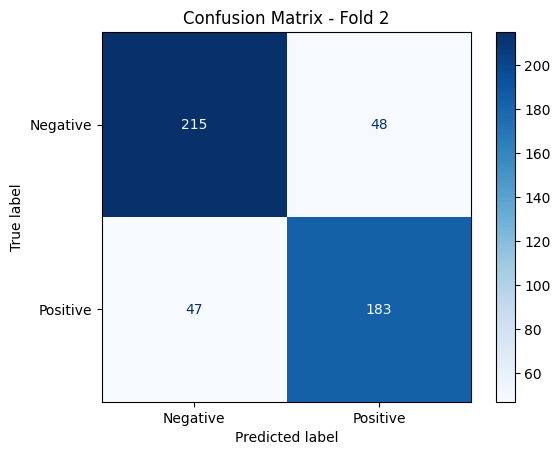

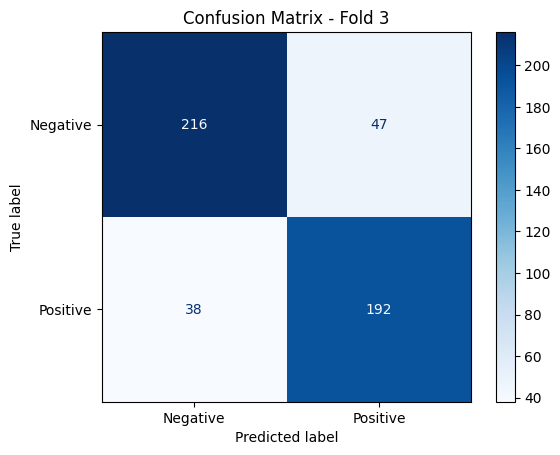

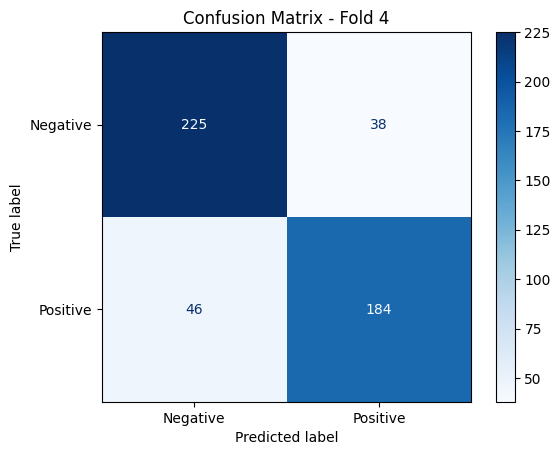

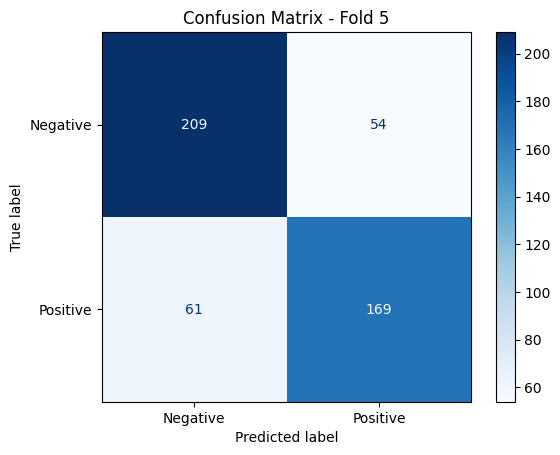

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precision_list = []
recall_list = []
pr_auc_list = []
conf_matrices = []
oof_true = []
oof_pred = []
oof_proba = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    param_dist = {
        'depth': randint(4, 10),
        'learning_rate': uniform(0.01, 0.2),
        'l2_leaf_reg': randint(1, 10),
        'iterations': randint(300, 1000)
    }

    base_model = CatBoostClassifier(verbose=0, random_seed=42)
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='accuracy',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    model = search.best_estimator_

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    oof_proba.extend(y_proba)

    acc = model.score(X_test, y_test)
    accuracies.append(acc)

    conf_matrices.append(confusion_matrix(y_test, y_pred))
    oof_true.extend(y_test)
    oof_pred.extend(y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    precision_list.append(precision)
    recall_list.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_list.append(pr_auc)

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=['Negative', 'Positive'], cmap='Blues')
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold}")
    plt.show()



✅ Average Accuracy: 81.30%


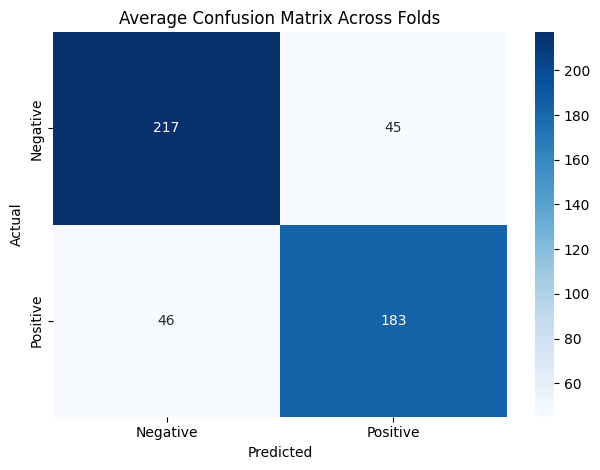

In [26]:
# Average Confusion Matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0).astype(int)
print(f"\n✅ Average Accuracy: {np.mean(accuracies) * 100:.2f}%")
plt.figure()
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Average Confusion Matrix Across Folds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



C:\Users\ANKITH\AppData\Local\Temp\ipykernel_15852\796292710.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


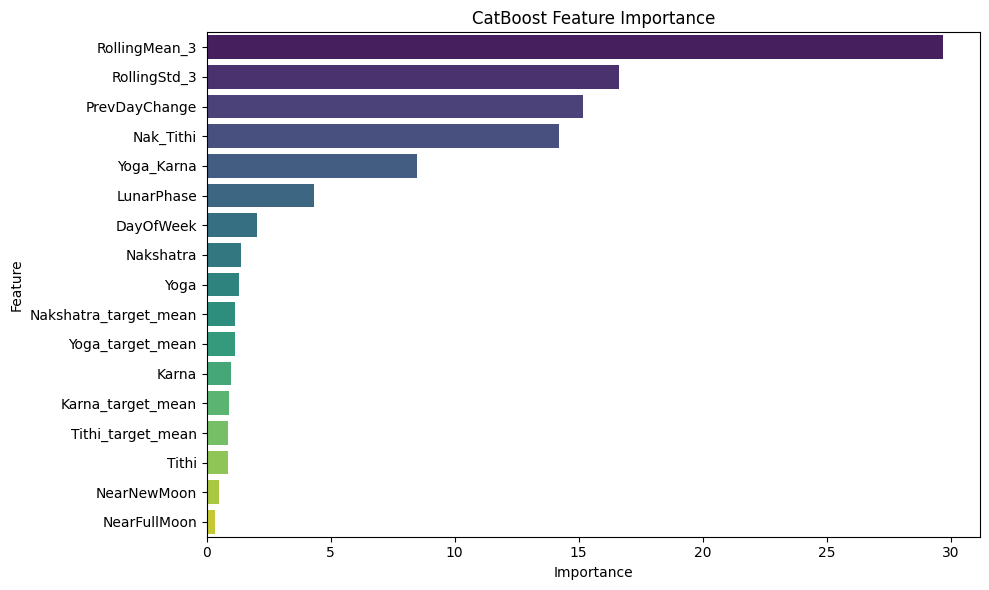

In [27]:
feature_importance = model.get_feature_importance()
feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

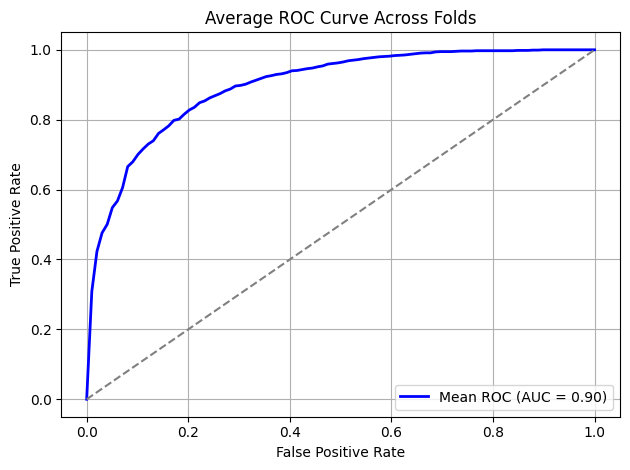

In [28]:
plt.figure()
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve Across Folds")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

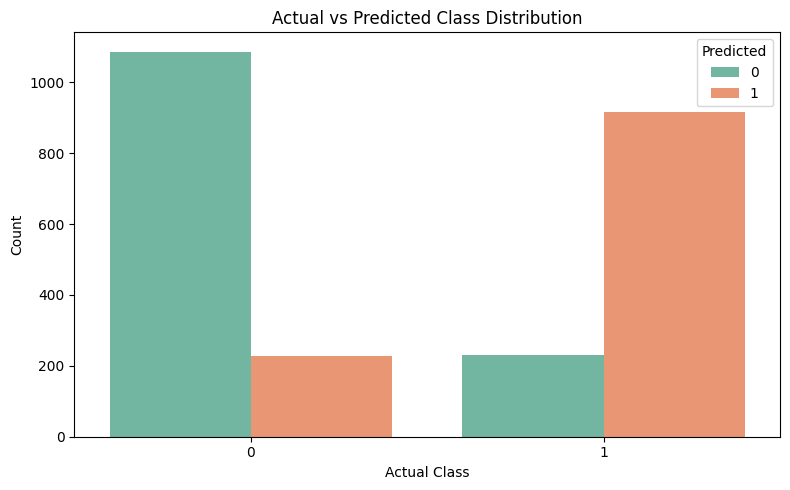

In [45]:
df_plot = pd.DataFrame({'Actual': oof_true, 'Predicted': oof_pred})
df_plot['Match'] = df_plot['Actual'] == df_plot['Predicted']

plt.figure(figsize=(8, 5))
sns.countplot(data=df_plot, x='Actual', hue='Predicted', palette='Set2')
plt.title("Actual vs Predicted Class Distribution")
plt.xlabel("Actual Class")
plt.ylabel("Count")
plt.legend(title="Predicted")
plt.tight_layout()
plt.show()


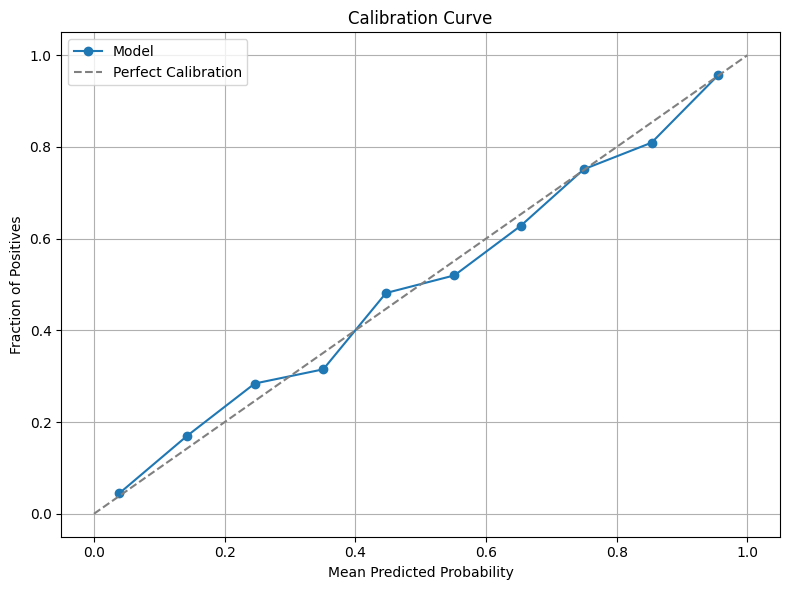

In [31]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(oof_true, oof_proba, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# 🔮 Predict from user input
user_input = {
    'Nakshatra': 'Mrigashira',
    'Tithi': 'Trayodasi',
    'Karna': 'Garija',
    'Yoga': 'Dhruva',
    'Date': '2025-07-22',
    'Percentagediff': 0  
}


In [33]:
user_input['Nak_Tithi'] = f"{user_input['Nakshatra']}_{user_input['Tithi']}"
user_input['Yoga_Karna'] = f"{user_input['Yoga']}_{user_input['Karna']}"
user_input['Date'] = pd.to_datetime(user_input['Date'])
user_input['DayOfWeek'] = user_input['Date'].dayofweek
user_input['LunarPhase'] = moon_phase(user_input['Date'])
user_input['NearFullMoon'] = int(user_input['LunarPhase'] > 95)
user_input['NearNewMoon'] = int(user_input['LunarPhase'] < 5)

user_df = pd.DataFrame([user_input])
user_df[categorical_cols + interaction_cols] = encoder.transform(user_df[categorical_cols + interaction_cols])

In [34]:

# Fill NA with median from training data (for new rows like rolling mean, etc.)
for col in extra_features:
    median_val = df[col].median()
    user_df[col] = median_val

user_encoded = user_df[feature_cols]
prediction = model.predict(user_encoded.values)[0]
label = target_label_map[int(prediction)]

print(f"\n📌 Prediction for input ({user_input['Nakshatra']}, {user_input['Tithi']}, {user_input['Karna']}, {user_input['Yoga']}): **{label}**")



📌 Prediction for input (Mrigashira, Trayodasi, Garija, Dhruva): **Positive**
